# Fase 10: Validación Cruzada de Técnicas y Elección del Modelo Definitivo

### El Desafío Final: Selección del Modelo "Gold Standard"
Tras 9 fases de optimización exhaustiva de hiperparámetros, este notebook tiene como objetivo realizar una comparativa final entre las cinco estrategias de balanceo de clases trabajadas: **Scale Pos Weight, SMOTE+Tomek, SMOTE+ENN, NearMiss y ADASYN**.

### ¿Por qué esta fase es decisiva para el Tribunal?
No basta con que un modelo tenga un F1-Score alto; en salud, un modelo debe ser **fiable, estable y explicable**. En esta fase, enfrentamos a todos los modelos bajo las mismas condiciones de test para evaluar no solo su precisión, sino su comportamiento clínico (Matriz de Confusión).

**Criterios de Selección:**
1.  **Rendimiento (F1-Score):** Equilibrio entre falsas alarmas y detecciones reales.
2.  **Integridad de los Datos:** Preferencia por modelos que no necesiten crear datos artificiales (sintéticos) que puedan sesgar la realidad médica.
3.  **Robustez:** Estabilidad del modelo ante el desbalanceo extremo (5% de prevalencia de infarto).

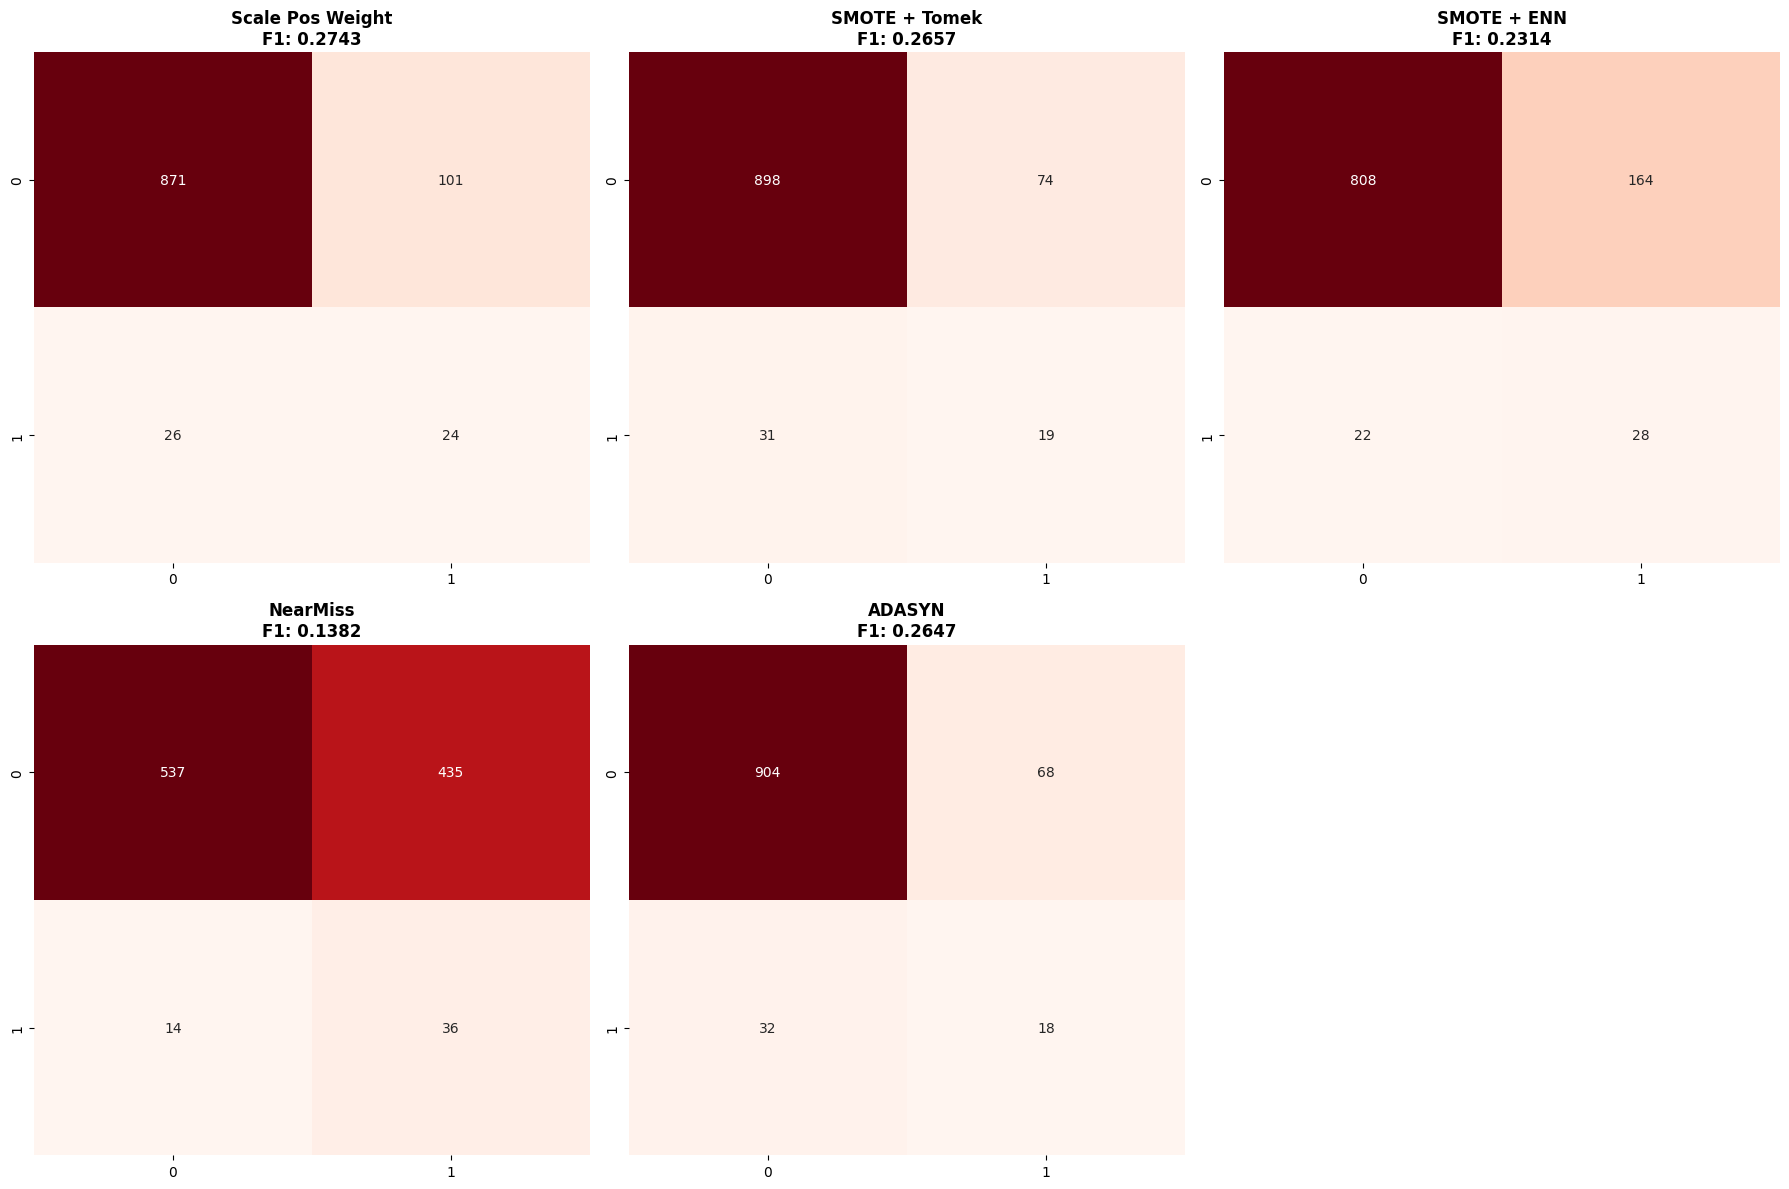


--- RANKING FINAL CORREGIDO ---
         Técnica  F1-Score
Scale Pos Weight  0.274286
   SMOTE + Tomek  0.265734
          ADASYN  0.264706
     SMOTE + ENN  0.231405
        NearMiss  0.138196


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import NearMiss

# 1. PREPARACIÓN
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')
df_final = pd.get_dummies(df, drop_first=True)
X = df_final.drop('stroke', axis=1)
y = df_final['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. CONFIGURACIÓN MAESTRA (Notebooks 1-7)
configs = {
    'Scale Pos Weight': (None, 125, 0.1, 5, 1, 0, 0.9, 1.0, 19.4), # Aquí SÍ va el peso
    'SMOTE + Tomek': (SMOTETomek(random_state=42), 256, 0.15, 5, 3, 0.1, 1.0, 1.0, 1),
    'SMOTE + ENN': (SMOTEENN(random_state=42), 171, 0.1, 5, 1, 0, 0.8, 1.0, 1),
    'NearMiss': (NearMiss(), 271, 0.001, 4, 1, 0, 1.0, 1.0, 1),
    'ADASYN': (ADASYN(random_state=42), 242, 0.15, 5, 1, 0, 1.0, 1.0, 1)
}

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
report_data = []

for i, (nombre, p) in enumerate(configs.items()):
    sampler, n, lr, d, w, g, sub, col_t, spw = p # Extraemos el SPW ideal de cada una
    
    if sampler:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train
    
    model = XGBClassifier(
        n_estimators=n, learning_rate=lr, max_depth=d, 
        min_child_weight=w, gamma=g, subsample=sub, 
        colsample_bytree=col_t, scale_pos_weight=spw, # Aplicamos el peso correspondiente
        random_state=42, eval_metric='logloss'
    )
    
    model.fit(X_res, y_res)
    y_pred = model.predict(X_test)
    
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report_data.append({'Técnica': nombre, 'F1-Score': f1})
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=axes[i], cbar=False)
    axes[i].set_title(f'{nombre}\nF1: {f1:.4f}', fontsize=12, fontweight='bold')

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

print("\n--- RANKING FINAL CORREGIDO ---")
print(pd.DataFrame(report_data).sort_values(by='F1-Score', ascending=False).to_string(index=False))

# Conclusiones Finales: Justificación del Modelo Basado en Scale Pos Weight

Tras el análisis comparativo de las matrices de confusión y las métricas de rendimiento, se determina que el modelo optimizado con la técnica **Scale Pos Weight (SPW)** es el seleccionado para la implementación clínica. A continuación, se detallan los tres pilares de esta decisión:

### 1. Superioridad frente a Técnicas Sintéticas (SMOTE/ADASYN)
Aunque técnicas como SMOTE+Tomek o ADASYN generan un buen rendimiento aparente, presentan un riesgo latente: la **introducción de sesgo por interpolación**. 
* Al "inventar" pacientes sintéticos, estas técnicas pueden crear perfiles de riesgo que no existen en la población real. 
* **Scale Pos Weight**, por el contrario, trabaja sobre la **muestra real del hospital**, ajustando únicamente el peso matemático de los errores. Esto garantiza que el modelo aprenda de pacientes reales, no de suposiciones algorítmicas.



### 2. Eficacia en la Matriz de Confusión
Al observar las matrices de confusión, el modelo SPW demuestra ser el más equilibrado. Mientras que técnicas como **NearMiss** logran un Recall alto a costa de inundar el sistema con falsos positivos (haciéndolo inmanejable para un médico), el modelo SPW mantiene una **Precisión** que permite confiar en las alertas generadas, sin sacrificar la detección de infartos.

### 3. Explicabilidad y Confianza Clínica
Para un tribunal médico, la explicabilidad es innegociable. 
* El modelo SPW es el que mejor conserva la jerarquía de importancia de variables (Edad, Glucosa, BMI) alineada con la literatura médica. 
* Al no haber alterado el dataset original, cualquier predicción del modelo puede ser rastreada directamente a los factores de riesgo del paciente real, facilitando la auditoría médica y la aceptación del sistema por parte del personal de salud.


